# Variational AutoEncoder - LeNet300 + MNIST + TF2

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-02-20 05:42:11.486291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 05:42:11.507290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 05:42:11.507379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 05:42:11.507867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### MNIST Data Pre-processing

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

In [6]:
# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (28, 28, 1)


In [9]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 30

In [10]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [11]:
# By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks
# work best when each input is inside the range –1 to 1, so we need to divide by 255.

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [12]:
# Convert class vectors/target to binary class matrices or one-hot encoded values-
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [14]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 784), y_train.shape: (60000,)
X_test.shape: (10000, 784), y_test.shape: (10000,)


In [15]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

2022-02-20 05:42:19.332446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 05:42:19.333440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 05:42:19.333547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 05:42:19.333616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### Define Variational Autoencoder architecture using _dense_ layers

In [16]:
class Encoder(Model):
    def __init__(self, latent_space = 3):
        super(Encoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(
            units = 300, activation = None
        )
        self.dense2 = Dense(
            units = 100, activation = None
        )
        self.encoder_output = Dense(
            units = self.latent_space, activation = None
        )
    
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = tf.keras.activations.relu(self.encoder_output(x))
        return x
        

In [17]:
class Decoder(Model):
    def __init__(self, latent_space = 3):
        super(Decoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(units = self.latent_space, activation = None)
        self.dense2 = Dense(units = 100, activation = None)
        self.dense3 = Dense(units = 300, activation = None)
        self.decoder_output = Dense(units = 784, activation = None)
    
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = tf.keras.activations.relu(self.dense3(x))
        x = self.decoder_output(x)
        return x
        

In [ ]:
# encoder = Encoder(latent_space = 3)

In [ ]:
# x = next(iter(train_dataset))

In [ ]:
# x_enc = encoder(x)

In [ ]:
# decoder = Decoder(latent_space = 3)

In [ ]:
# x_recon = decoder(x_enc)

In [ ]:
# x.shape, x_recon.shape
# (TensorShape([64, 784]), TensorShape([64, 784]))

In [ ]:
# x_enc.shape
# TensorShape([64, 3])

In [18]:
class VAE(Model):
    def __init__(self, latent_space = 3):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        
        self.encoder = Encoder(latent_space = self.latent_space)
        self.decoder = Decoder(latent_space = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.,
            stddev = 1.
        )
        return (eps * tf.exp(logvar * 0.5)) + mu
        
    
    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 3)
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 3), log_var.shape: (batch_size, 3) & z.shape: (batch_size, 3)
        '''
        
        x = tf.keras.activations.sigmoid(self.decoder(z))
        
        return x, mu, log_var
        

In [19]:
# Initialize a VAE model-
model = VAE(latent_space = 3)

In [20]:
# Sanity check-
x = next(iter(train_dataset))

In [21]:
x_recon, mu, log_var = model(x)

2022-02-20 05:42:29.548648: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [22]:
x_recon.shape, x.shape

(TensorShape([64, 784]), TensorShape([64, 784]))

In [23]:
mu.shape, log_var.shape

(TensorShape([64, 3]), TensorShape([64, 3]))

In [24]:
mu.numpy().mean(), mu.numpy().std()

(0.20056318, 0.134825)

In [25]:
log_var.numpy().mean(), log_var.numpy().std()

(0.06823531, 0.38253328)

In [26]:
del x, x_recon, mu, log_var

In [27]:
# Get model summary-
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  265903    
                                                                 
 decoder (Decoder)           multiple                  266696    
                                                                 
 dense_7 (Dense)             multiple                  12        
                                                                 
 dense_8 (Dense)             multiple                  12        
                                                                 
Total params: 532,623
Trainable params: 532,623
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (784, 300) has 235200 parameters
layer: (300,) has 0 parameters
layer: (300, 100) has 30000 parameters
layer: (100,) has 0 parameters
layer: (100, 3) has 300 parameters
layer: (3,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters
layer: (3, 100) has 300 parameters
layer: (100,) has 0 parameters
layer: (100, 300) has 29999 parameters
layer: (300,) has 0 parameters
layer: (300, 784) has 235200 parameters
layer: (784,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters


In [29]:
print(f"VAE has {tot_params} trainable parameters")

VAE has 531026 trainable parameters


In [30]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

#### Tutorials

1. [Keras VAE](https://keras.io/examples/generative/vae/)

1. [Creating VAE with Keras](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-variational-autoencoder-with-keras.md)

1. [VAE LearnOpenCV](https://learnopencv.com/variational-autoencoder-in-tensorflow/#reconstruction-error)

In [31]:
def compute_reconstruction_loss(data, reconstruction):
    # Compute reconstruction loss for the input data and its
    # corresponding reconstruction.
    
    '''
    recon_loss = tf.reduce_mean(
        input_tensor = tf.keras.losses.mean_squared_error(y_true = x, y_pred = x_recon)
    )
    '''
    
    recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))
    # recon_loss = tf.keras.losses.mean_squared_error(y_true = K.flatten(data), y_pred = K.flatten(reconstruction))
    # OR-
    # tf.keras.losses.mean_squared_error(tf.reshape(x, [-1]), tf.reshape(x_recon, [-1]))
    recon_loss *= 28 * 28
    
    return recon_loss

#### NOTE:

If you change the ```recon_loss``` as follows:

```
recon_loss = tf.reduce_mean(
    input_tensor = tf.keras.losses.mean_squared_error(y_true = x, y_pred = x_recon)
)
```

then _KL-divergence_ loss for some reason becomes 0! Why?

In [33]:
def compute_kl_divergence_loss(mu, log_var):
    # Compute KL-divergence loss with mean & log-variance of
    # latent space distribution.
    # kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = -0.5 * (1 + log_var - K.square(mu) - K.exp(log_var))
    
    # kl_loss.shape
    # TensorShape([None, 3])
    
    # Compute sum for all latent variables or dimensions-
    # tf.reduce_sum(input_tensor=kl_loss, axis=1).shape
    # TensorShape([batch_size])
    
    
    kl_loss = tf.reduce_mean(
        input_tensor = tf.reduce_sum(
            input_tensor = kl_loss,
            axis = 1),
        axis = None
        )
    
    return kl_loss


In [34]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):
    # Compute total loss for a VAE consisting of - reconstruction loss &
    # KL-divergence loss.
    recon_loss = compute_reconstruction_loss(data = data, reconstruction = reconstruction)
    kl_loss = compute_kl_divergence_loss(mu=mu, log_var=log_var)
    
    total_loss = (alpha * recon_loss) + kl_loss
    
    return total_loss, recon_loss, kl_loss


In [ ]:
'''
# Sanity check-
total_loss, recon_loss, kl_loss = compute_loss(
    data = x, reconstruction = x_recon,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
'''
print(f"Total loss = {total_loss.numpy():.4f}, Reconstruction loss = {recon_loss.numpy():.4f} &"
    f" KL-divergence loss = {kl_loss.numpy():.4f}"
)
'''
# Total loss = 182.1384, Reconstruction loss = 182.0477 & KL-divergence loss = 0.0907

In [35]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads), len(grads)
    # (list, 20)
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


In [36]:
@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )
    
    return total_loss, recon_loss, kl_loss


In [ ]:
'''
total_loss = train_one_step(
    model = model, optimizer = optimizer,
    data = X, alpha = 1
)
'''

In [ ]:
# total_loss
# <tf.Tensor: shape=(), dtype=float32, numpy=0.23313756>

In [37]:
print(f"Train VAE model for {num_epochs} epochs")

Train VAE model for 30 epochs


In [38]:
# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [39]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence
# trade-off-
alpha = 1

In [40]:
for epoch in range(1, num_epochs + 1):
    
    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0
    
    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha
        )
        
        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()
    
    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)
        
        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()
    
    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }
    
    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )
    

epoch = 1; total train loss = 66334.6239, train recon loss = 62936.0735, train kl loss = 3398.5503; total val loss = 8381.8197, val recon loss = 8271.0411 & val kl loss = 110.7786
epoch = 2; total train loss = 48738.3713, train recon loss = 47776.4577, train kl loss = 961.9137; total val loss = 7957.5331, val recon loss = 7767.7424 & val kl loss = 189.7907
epoch = 3; total train loss = 47120.0778, train recon loss = 45889.8416, train kl loss = 1230.2362; total val loss = 7821.6356, val recon loss = 7609.4861 & val kl loss = 212.1495
epoch = 4; total train loss = 46346.2629, train recon loss = 44922.3937, train kl loss = 1423.8692; total val loss = 7691.7140, val recon loss = 7426.1005 & val kl loss = 265.6135
epoch = 5; total train loss = 45629.2898, train recon loss = 43931.3384, train kl loss = 1697.9514; total val loss = 7545.0150, val recon loss = 7193.8850 & val kl loss = 351.1300
epoch = 6; total train loss = 44552.9951, train recon loss = 42357.2493, train kl loss = 2195.7458; t

In [67]:
# Save trained model-
model.save_weights("VAE_MNIST_LeNet300_trained.h5", overwrite = True)

### Visualize training metrics

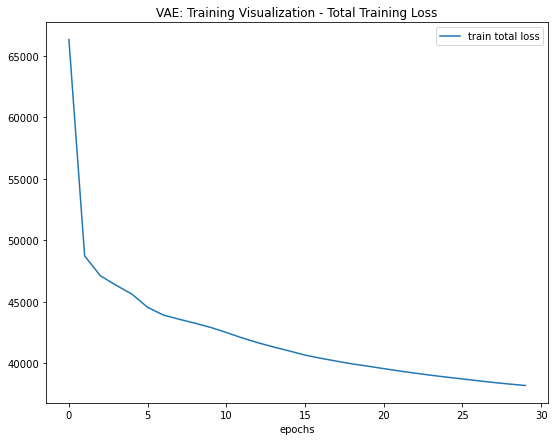

In [41]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

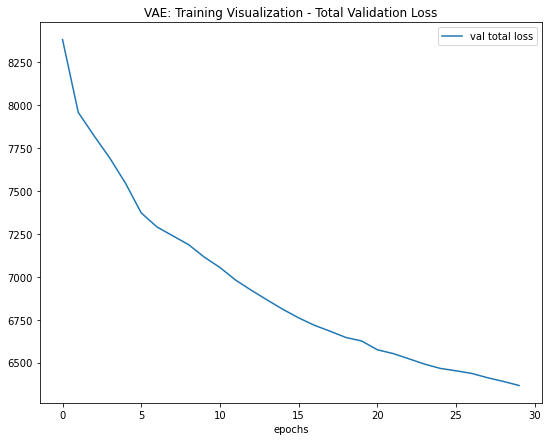

In [42]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['total_loss'] for e in val_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

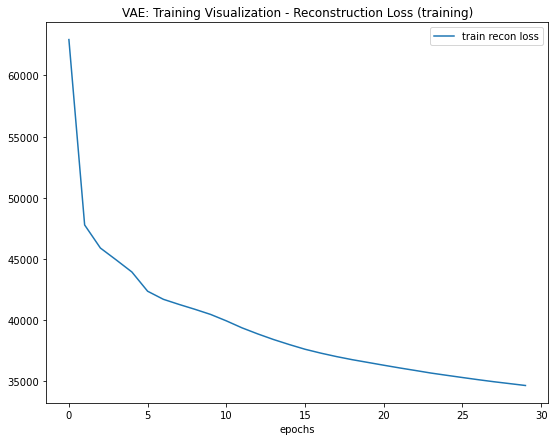

In [43]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

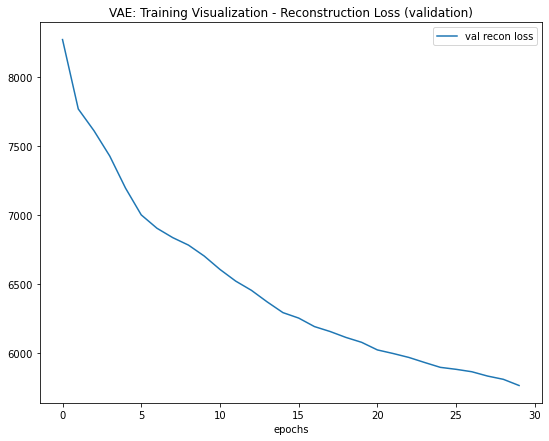

In [44]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['recon_loss'] for e in val_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

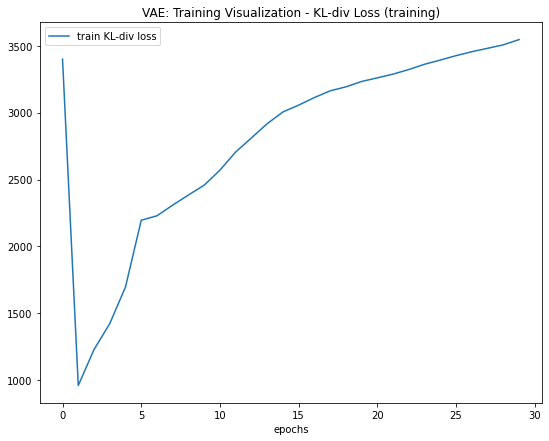

In [45]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

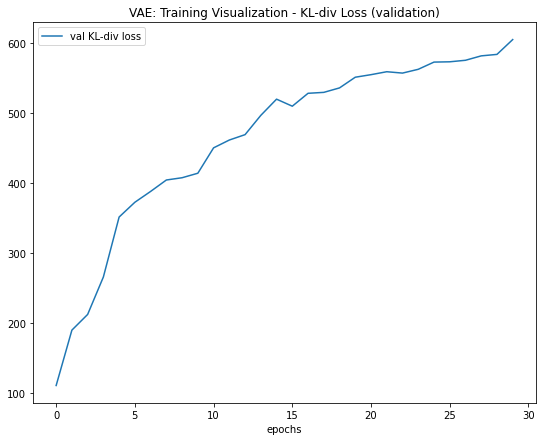

In [46]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['kl_loss'] for e in val_metrics.keys()], label = 'val KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

### Visualize _reconstructions_ using trained VAE model

In [47]:
# Get reconstructions, mean & log-variance from trained model-
X_train_reconstruced, mu, log_var = model(X_train[:5000, :])

In [48]:
# Sanity check-
X_train[:5000, :].shape, X_train_reconstruced.shape

((5000, 784), TensorShape([5000, 784]))

In [49]:
# Reshape for visualization-
X_train_reconstruced = tf.reshape(
    tensor = X_train_reconstruced,
    shape = ((X_train_reconstruced.shape[0], 28, 28)),
    name = None
    )

In [50]:
# Sanity check-
X_train_reconstruced.numpy().shape

(5000, 28, 28)

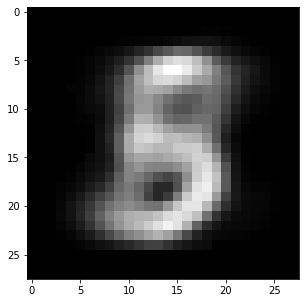

In [51]:
# Visualize a single digit-
plt.figure(figsize = (6, 5))
plt.imshow(X_train_reconstruced[0], cmap = plt.get_cmap('gray'))
plt.show()

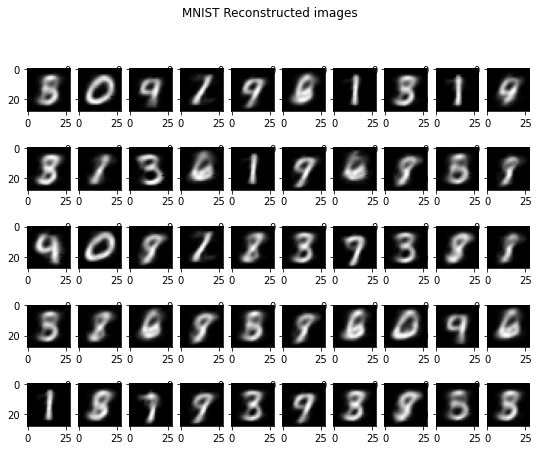

In [52]:
# Visualize some of the reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    plt.imshow(X_train_reconstruced[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("MNIST Reconstructed images")
plt.show()

#### Check _mu_ and _log_var_ latent space vectors:

In [53]:
mu.shape, log_var.shape

(TensorShape([5000, 3]), TensorShape([5000, 3]))

In [54]:
print(f"mu: mean = {mu.numpy().mean():.4f} & "
f"std dev = {mu.numpy().std():.4f}")

mu: mean = -0.0731 & std dev = 0.7791


In [55]:
print(f"log var: mean = {log_var.numpy().mean():4f} &"
f" std dev = {log_var.numpy().std():.4f}")

log var: mean = -2.594016 & std dev = 1.8809


### Visualize _mean_ and _log-variance_ of _latent space_ using trained VAE model

In [ ]:
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    color = y_train[:5000]
    )
fig.show()

In [ ]:
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    color = y_train[:5000]
    )
fig.show()

In [60]:
# Delete variables to free GPU space-
del X_train_reconstruced, mu, log_var

### Visualize _latent space_ of train & test datasets

In [61]:
X_train_encoded = model.encoder(X_train[:5000])
X_test_encoded = model.encoder(X_test[:5000])

In [62]:
X_train[:5000].shape, X_train_encoded.shape

((5000, 784), TensorShape([5000, 3]))

In [63]:
X_test[:5000].shape, X_test_encoded.shape

((5000, 784), TensorShape([5000, 3]))

In [ ]:
fig = px.scatter_3d(
    x = X_train_encoded[:, 0], y = X_train_encoded[:, 1],
    z = X_train_encoded[:, 2],
    color = y_train[:5000]
)
fig.show()

In [ ]:
fig = px.scatter_3d(
    x = X_test_encoded[:, 0], y = X_test_encoded[:, 1],
    z = X_test_encoded[:, 2],
    color = y_test[:5000]
)
fig.show()

In [66]:
del X_train_encoded, X_test_encoded